In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#Feature tools for "Deep Feature Synthesis"
import featuretools as ft

import pyodbc

## Representing Data with EntitySets
An `EntitySet` is a collection of entities and the relationships between them. They are useful for preparing raw, structured datasets for feature engineering. While many functions in Featuretools take `entities` and `relationships` as separate arguments, it is recommended to create an `EntitySet`, so you can more easily manipulate your data as needed.

### The Raw Data
Below we have a two tables of data (represented as Pandas DataFrames) related to customer transactions. The first is a merge of transactions, sessions, and customers so that the result looks like something you might see in a log file:

In [2]:
data = ft.demo.load_mock_customer()

In [3]:
transactions_df = data["transactions"].merge(data["sessions"]).merge(data["customers"])

In [4]:
transactions_df.sample(10)

,transaction_id,session_id,transaction_time,product_id,amount,customer_id,device,session_start,zip_code,join_date,date_of_birth
264,380,21,2014-01-01 05:14:10,5,57.09,4,desktop,2014-01-01 05:02:15,60091,2011-04-08 20:08:14,2006-08-15
19,244,10,2014-01-01 02:34:55,2,116.95,2,tablet,2014-01-01 02:31:40,13244,2012-04-15 23:31:04,1986-08-18
314,299,6,2014-01-01 01:32:05,4,64.99,1,tablet,2014-01-01 01:23:25,60091,2011-04-17 10:48:33,1994-07-18
290,78,4,2014-01-01 00:54:10,1,37.50,1,mobile,2014-01-01 00:44:25,60091,2011-04-17 10:48:33,1994-07-18
379,457,27,2014-01-01 06:37:35,1,19.16,1,mobile,2014-01-01 06:34:20,60091,2011-04-17 10:48:33,1994-07-18
335,477,9,2014-01-01 02:30:35,3,41.70,1,desktop,2014-01-01 02:15:25,60091,2011-04-17 10:48:33,1994-07-18
293,103,4,2014-01-01 00:57:25,5,20.79,1,mobile,2014-01-01 00:44:25,60091,2011-04-17 10:48:33,1994-07-18
271,390,22,2014-01-01 05:21:45,2,54.83,4,desktop,2014-01-01 05:21:45,60091,2011-04-08 20:08:14,2006-08-15
404,476,29,2014-01-01 07:24:10,4,121.59,1,mobile,2014-01-01 07:10:05,60091,2011-04-17 10:48:33,1994-07-18
179,90,3,2014-01-01 00:35:45,1,75.73,4,mobile,2014-01-01 00:28:10,60091,2011-04-08 20:08:14,2006-08-15


And the second dataframe is a list of products involved in those transactions.

In [5]:
products_df = data["products"]

In [6]:
products_df

,product_id,brand
0,1,B
1,2,B
2,3,B
3,4,B
4,5,A


### Create an "Entity Set"
First, we initialize an EntitySet. If you’d like to give it name, you can optionally provide an id to the constructor.

In [7]:
es = ft.EntitySet(id="customer_data")

### Adding Entities
To get started, we load the transactions dataframe as an entity.

In [8]:
es = es.entity_from_dataframe(entity_id="transactions",
                                dataframe=transactions_df,
                                index="transaction_id",
                                time_index="transaction_time",
                                variable_types={"product_id": ft.variable_types.Categorical,
                                "zip_code": ft.variable_types.ZIPCode})

In [9]:
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
  Relationships:
    No relationships

This method loads each column in the dataframe in as a variable. We can see the variables in an entity using the code below.

In [10]:
es["transactions"].variables

[<Variable: transaction_id (dtype = index)>,
 <Variable: session_id (dtype = numeric)>,
 <Variable: transaction_time (dtype: datetime_time_index, format: None)>,
 <Variable: amount (dtype = numeric)>,
 <Variable: customer_id (dtype = numeric)>,
 <Variable: device (dtype = categorical)>,
 <Variable: session_start (dtype: datetime, format: None)>,
 <Variable: join_date (dtype: datetime, format: None)>,
 <Variable: date_of_birth (dtype: datetime, format: None)>,
 <Variable: product_id (dtype = categorical)>,
 <Variable: zip_code (dtype = zipcode)>]

es.plot() visualizes the entity set and the relationships between them

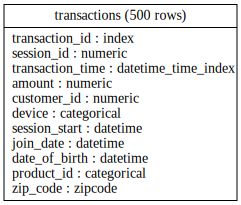

In [11]:
es.plot()

In the call to `entity_from_dataframe`, we specified three important parameters

The `index` parameter specifies the column that uniquely identifies rows in the dataframe

The `time_index` parameter tells Featuretools when the data was created.

The `variable_types` parameter indicates that “product_id” should be interpreted as a Categorical variable, even though it just an integer in the underlying data.

Now, we can do that same thing with our products dataframe

In [12]:
es = es.entity_from_dataframe(entity_id="products",
                                dataframe=products_df,
                                index="product_id")

In [13]:
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
    products [Rows: 5, Columns: 2]
  Relationships:
    No relationships

With two entities in our entity set, we can add a relationship between them.

### Adding a Relationship
We want to relate these two entities by the columns called “product_id” in each entity. Each product has multiple transactions associated with it, so it is called it the parent entity, while the transactions entity is known as the child entity. When specifying relationships we list the variable in the parent entity first. Note that each `ft.Relationship` must denote a one-to-many relationship rather than a relationship which is one-to-one or many-to-many.

In [14]:
new_relationship = ft.Relationship(es["products"]["product_id"],
                                    es["transactions"]["product_id"])

In [15]:
es = es.add_relationship(new_relationship)

Now, we see the relationship has been added to our entity set.

In [16]:
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 11]
    products [Rows: 5, Columns: 2]
  Relationships:
    transactions.product_id -> products.product_id

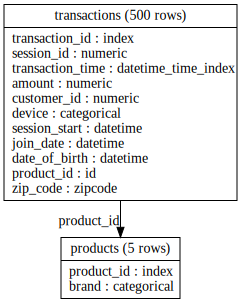

In [17]:
es.plot()

### Creating entity from existing table
When working with raw data, it is common to have sufficient information to justify the creation of new entities. In order to create a new entity and relationship for sessions, we “normalize” the transaction entity.

In [18]:
es = es.normalize_entity(base_entity_id="transactions",
                            new_entity_id="sessions",
                            index="session_id",
                            make_time_index="session_start",
                            additional_variables=["device", "customer_id", "zip_code", "session_start", "join_date"])

In [19]:
es

Entityset: customer_data
  Entities:
    transactions [Rows: 500, Columns: 6]
    products [Rows: 5, Columns: 2]
    sessions [Rows: 35, Columns: 6]
  Relationships:
    transactions.product_id -> products.product_id
    transactions.session_id -> sessions.session_id

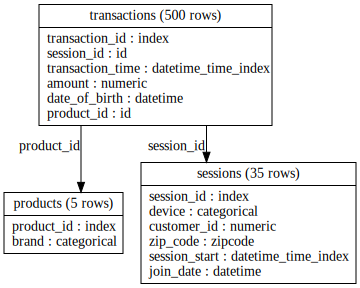

In [20]:
es.plot()

Looking at the output above, we see this method did two operations

1. It created a new entity called “sessions” based on the “session_id” variable in “transactions”
2. It added a relationship connecting “transactions” and “sessions”.

If we look at the variables in transactions and the new sessions entity, we see two more operations that were performed automatically.

In [21]:
es["transactions"].variables

[<Variable: transaction_id (dtype = index)>,
 <Variable: session_id (dtype = id)>,
 <Variable: transaction_time (dtype: datetime_time_index, format: None)>,
 <Variable: amount (dtype = numeric)>,
 <Variable: date_of_birth (dtype: datetime, format: None)>,
 <Variable: product_id (dtype = id)>]

In [22]:
es["sessions"].variables

[<Variable: session_id (dtype = index)>,
 <Variable: device (dtype = categorical)>,
 <Variable: customer_id (dtype = numeric)>,
 <Variable: zip_code (dtype = zipcode)>,
 <Variable: session_start (dtype: datetime_time_index, format: None)>,
 <Variable: join_date (dtype: datetime, format: None)>]

1. It removed “device”, “customer_id”, “zip_code”, “session_start” and “join_date” from “transactions” and created a new variables in the sessions entity. This reduces redundant information as the those properties of a session don’t change between transactions.

2. It marked “session_start” as a time index in the new sessions entity to indicate the beginning of a session. By default, unless it’s explicitly set to another variable, `normalize_entity` would have made a “first_transactions_time” in this entity. If we don’t want this variable to be created, we can set `make_time_index=False`.

If we look at the dataframes, can see what the `normalize_entity` did to the actual data.

In [23]:
es["sessions"].df.head(5)

,session_id,device,customer_id,zip_code,session_start,join_date
1,1,desktop,2,13244,2014-01-01 00:00:00,2012-04-15 23:31:04
2,2,mobile,5,60091,2014-01-01 00:17:20,2010-07-17 05:27:50
3,3,mobile,4,60091,2014-01-01 00:28:10,2011-04-08 20:08:14
4,4,mobile,1,60091,2014-01-01 00:44:25,2011-04-17 10:48:33
5,5,mobile,4,60091,2014-01-01 01:11:30,2011-04-08 20:08:14


In [24]:
es["transactions"].df.head(5)

,transaction_id,session_id,transaction_time,amount,date_of_birth,product_id
298,298,1,2014-01-01 00:00:00,127.64,1986-08-18,5
2,2,1,2014-01-01 00:01:05,109.48,1986-08-18,2
308,308,1,2014-01-01 00:02:10,95.06,1986-08-18,3
116,116,1,2014-01-01 00:03:15,78.92,1986-08-18,4
371,371,1,2014-01-01 00:04:20,31.54,1986-08-18,3


To finish preparing this dataset, create a “customers” entity using the same method call.

In [25]:
es = es.normalize_entity(base_entity_id="sessions",
                            new_entity_id="customers",
                            index="customer_id",
                            make_time_index="join_date",
                            additional_variables=["zip_code", "join_date"])

### Using the EntitySet
Finally, we are ready to use this EntitySet with any functionality within Featuretools. For example, let’s build a feature matrix for each product in our dataset.

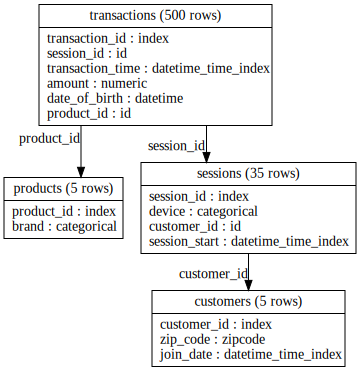

In [29]:
es.plot()

In [35]:
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity="customers")

In [36]:
feature_matrix

,zip_code,COUNT(sessions),NUM_UNIQUE(sessions.device),MODE(sessions.device),SUM(transactions.amount),STD(transactions.amount),MAX(transactions.amount),SKEW(transactions.amount),MIN(transactions.amount),MEAN(transactions.amount),...,NUM_UNIQUE(sessions.MONTH(session_start)),MODE(sessions.MODE(transactions.product_id)),MODE(sessions.YEAR(session_start)),MODE(sessions.WEEKDAY(session_start)),MODE(sessions.DAY(session_start)),MODE(sessions.MONTH(session_start)),NUM_UNIQUE(transactions.sessions.device),NUM_UNIQUE(transactions.sessions.customer_id),MODE(transactions.sessions.device),MODE(transactions.sessions.customer_id)
customer_id,,,,,,,,,,,,,,,,,,,,,
5,60091,6,3,mobile,6349.66,44.095630,149.02,-0.025941,7.55,80.375443,...,1,3,2014,2,1,1,3,1,mobile,5
4,60091,8,3,mobile,8727.68,45.068765,149.95,-0.036348,5.73,80.070459,...,1,1,2014,2,1,1,3,1,mobile,4
1,60091,8,3,mobile,9025.62,40.442059,139.43,0.019698,5.81,71.631905,...,1,4,2014,2,1,1,3,1,mobile,1
3,13244,6,3,desktop,6236.62,43.683296,149.15,0.418230,5.89,67.060430,...,1,1,2014,2,1,1,3,1,desktop,3
2,13244,7,3,desktop,7200.28,37.705178,146.81,0.098259,8.73,77.422366,...,1,3,2014,2,1,1,3,1,desktop,2
